In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# df = pd.read_csv('Churn_Modelling.csv')
# df
from google.colab import files
uploaded = files.upload()

Saving Churn_Modelling.csv to Churn_Modelling.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Churn_Modelling.csv']))

In [35]:
X = df.iloc[:, 3:13].values # higher bound is excluded so 12 + 1 

In [36]:
y = df.iloc[:, 13].values

In [37]:
# Encode categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelEncoder_X_1 = LabelEncoder()          
X[:, 1] = labelEncoder_X_1.fit_transform(X[:, 1])         # for country 

labelEncoder_X_2 = LabelEncoder()
X[:, 2] = labelEncoder_X_2.fit_transform(X[:, 2])        # for gender

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('encoder', OneHotEncoder(), [1])], 
                        remainder='passthrough')
X = np.array(ct.fit_transform(X), dtype=np.float)

X = X[:, 1:] # avoid the dummy variable trap

In [38]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

> **feature scaling is absolutely necessary for neural networks**

In [39]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

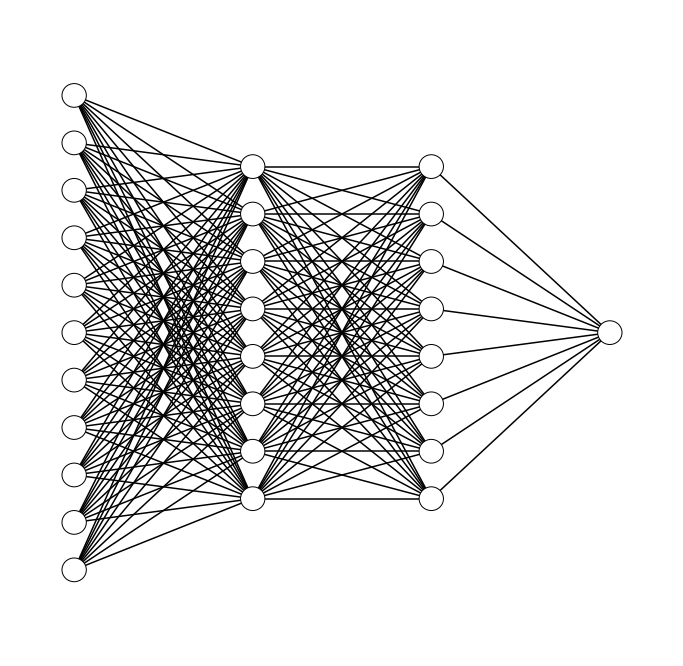

In [40]:
# just to draw the neural network in matplotlib

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

                
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [11, 8, 8, 1])              

In [41]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()

> no. of hidden neurons (nh) = (2/3)* (no.of input neurons + no.of output neurons)

In [42]:
nh = int((2/3)*(11+1))
nh

8

In [43]:
# Hidden layer 1
classifier.add(Dense(activation='relu', units=nh,
                     kernel_initializer='uniform', input_dim=11))

In [44]:
# Hidden layer 2
classifier.add(Dense(activation='relu', units=nh, kernel_initializer='uniform'))

In [45]:
# the output layer
# if dealing with several categories, will need multiple output neurons, and activation function would be softmax
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform")) 

# for getting the probabilistic o/p use sigmoid 

In [46]:
# Compiling the ANN
# adam is stochastic gradient descent algorithm
# use logarithmic loss function with sigmoid function (binary_crossentropy with 1 category)
# metric expect analysing parameters in a list, e.g. accuract

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [47]:
# Fit ANN to training set
# by setting verbose to 0 you wont get any visualization 
history = classifier.fit(X_train, y_train, batch_size=10, epochs=50)

Epoch 1/50
800/800 [==============================] - 1s 738us/step - loss: 0.4935 - accuracy: 0.7954
Epoch 2/50
800/800 [==============================] - 1s 739us/step - loss: 0.4266 - accuracy: 0.7960
Epoch 3/50
800/800 [==============================] - 1s 713us/step - loss: 0.4187 - accuracy: 0.8211
Epoch 4/50
800/800 [==============================] - 1s 743us/step - loss: 0.4128 - accuracy: 0.8331
Epoch 5/50
800/800 [==============================] - 1s 735us/step - loss: 0.4083 - accuracy: 0.8336
Epoch 6/50
800/800 [==============================] - 1s 756us/step - loss: 0.4057 - accuracy: 0.8361
Epoch 7/50
800/800 [==============================] - 1s 741us/step - loss: 0.4037 - accuracy: 0.8332
Epoch 8/50
800/800 [==============================] - 1s 726us/step - loss: 0.4022 - accuracy: 0.8338
Epoch 9/50
800/800 [==============================] - 1s 737us/step - loss: 0.4005 - accuracy: 0.8341
Epoch 10/50
800/800 [==============================] - 1s 730us/step - loss: 0.399

In [48]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


Text(0.5, 0, 'epoch')

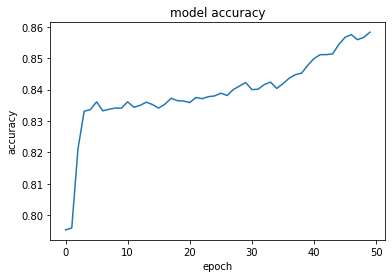

In [49]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

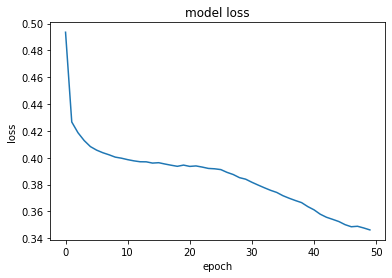

In [50]:
# summarize history for loss
plt.plot(classifier.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [51]:
# from livelossplot import PlotLossesKeras
# classifier.fit(X_train, y_train, batch_size=10,
#                epochs=100,
#                validation_data=(X_test, y_test),
#                callbacks=[PlotLossesKeras()],
#                verbose=0)

In [52]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [53]:
# threshold to change y_pred from probability to true/false
y_pred = (y_pred > 0.5)

In [54]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [61]:
print(cm)
(1475+223)/(2000)

[[1475  120]
 [ 182  223]]


0.849

In [56]:
# 86% accuracy 

In [57]:
result = classifier.evaluate(X_test,  y_test, verbose=2)

dict(zip(classifier.metrics_names, result))  # zip pairs 1-1, 2-2, 3-3


63/63 - 0s - loss: 0.3476 - accuracy: 0.8490


{'accuracy': 0.8489999771118164, 'loss': 0.347552090883255}

In [58]:
# for a single new data predict the outcome 
new_prediction = classifier.predict(sc.transform(np.array([[0.0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])))
new_prediction

array([[0.04101485]], dtype=float32)

In [59]:
new_prediction = (new_prediction > 0.5)
new_prediction

array([[False]])

In [62]:
# run it on google TPU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(activation='relu', units=6,kernel_initializer='uniform', input_dim=11))     # 6 or 8 doesn't matter              
    classifier.add(Dense(activation='relu', units=6, kernel_initializer='uniform'))
    classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform")) 
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier


classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, nb_epoch = 50)
accuracies = cross_val_score(estimator= classifier, X= X_train, y= y_train, cv=10, n_jobs=-1)
mean = accuracies.mean()
varience = accuracies.std()
print(accuracies)
print("mean - ", mean * 100 , "% ", "varience - ", varience* 100 , "% ")


[0.78625    0.79000002 0.80000001 0.78250003 0.81625003 0.81
 0.78750002 0.79374999 0.79874998 0.79500002]
mean -  79.60000097751617 %  varience -  1.010569052791386 % 
